<a href="https://colab.research.google.com/github/clashgamer123/SOC_Pytorch/blob/main/mnist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We are implementing a Convolutional Neural Network that will be trained with the standard MNIST data set.


Lets import all the libraries we are going to use.

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

Preparing the MNIST data set.
The mean = 0.1307 and std = 0.3081 are of the entire standard MNIST data set. By normalising the entire data set with these values our model can be trained more efficiently as the convergence of the weights is faster.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.1307), std = (0.3081))
])

mnist_dataset = datasets.MNIST(root = './dataset', train = True, download = 'True', transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 49781255.08it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 21639102.15it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 45173855.43it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5593226.30it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Let us display the first image of this data set for verification purposes.

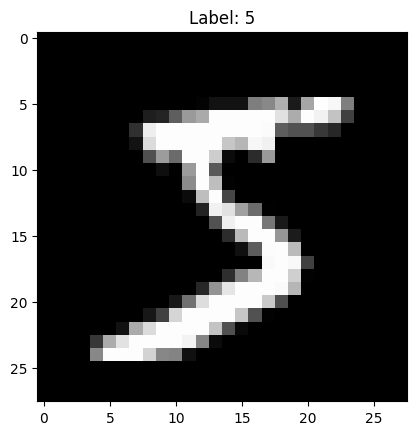

In [ ]:
image, label = mnist_dataset[0]
# mnist_dataset is an array with each element being a tuple containing the normalized image in tensor form with dimension channels x height x width
# and the label.
plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f'Label: {label}')
plt.show()

Let us now segregate the data set into the training data set and the testing data set.

In [ ]:
training_datasize = int(0.8*len(mnist_dataset))
testing_datasize = len(mnist_dataset) - training_datasize

# Split the data randomly using random_split in torch.utils.data. Can be split using slicing of arrays too after using shuffle on the array.
training_data, testing_data = random_split(mnist_dataset, [training_datasize, testing_datasize])

# Load the data in batches.
train_loader = DataLoader(training_data, batch_size = 64, shuffle=True)
test_loader = DataLoader(testing_data, batch_size = 1000, shuffle=True)

Now let us design our Neural Network Model from the Base Class available in torch for Neural Networks ie nn.Module.

In [ ]:
class NN_Model (nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1) # We are using same padding.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # We are going to use max pooling layers of size 2 and stride 2. Two such layers means the final size = 64*7*7
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)

        self.relu = nn.ReLU()  # RELU activation.

        # Let us stick to the default initializations.

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2) # Size = (size-kernel_size)/stride + 1 = size/2 in this case
        x = self.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)

        # Now we need to flatten the array to uni dimension. Note that x.size[0] is batch_size and hence should remain same.
        x = x.reshape(x.size(0), -1)

        x = self.fc1(x)
        x = self.fc2(x)

        return x

Now let us complete our model by defining the optimizer and the Loss computation criteria used.

In [ ]:
model = NN_Model()

optimizer = optim.Adam(model.parameters(), lr= 1e-3)
loss_criterion = nn.CrossEntropyLoss()

Our Model is now complete.
Let us now define the Train function.

In [ ]:
def Train_Model(model, train_loader, optimizer, loss_criterion, epochs = 5):
    for epoch in range(epochs):
        model.train()
        cum_loss = 0
        batch_no = 0
        for inputs, labels in train_loader:
            outputs_model = model.forward(inputs)  # Array of output labels from model.ipynb

            optimizer.zero_grad()
            Loss = loss_criterion(outputs_model, labels) # A tensor
            Loss.backward()

            # Update the weights and biases for this batch.
            optimizer.step()

            # Lets add the loss to the cum_loss so as to find the average loss for this epoch.
            cum_loss += Loss*inputs.size(0)
            batch_no+=1

        cum_loss = cum_loss / batch_no

        print(f'Cummulative Loss for epoch = {epoch} : {cum_loss} ')

        # Done

Let us also make an evaluation function that determines the accuracy of the model after the training is over.
Let us just use a simple estimate of (number of correct matches)/(size of test data) * 100.

In [ ]:
def Accuracy(model, test_loader):
    model.eval()
    test_datasize = len(test_loader.dataset)
    valid_preds = 0

    with torch.no_grad():
        for data, label in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            valid_preds += (predicted == label).sum().item()

    accuracy = (valid_preds / test_datasize) * 100
    print(f"Accuracy = {accuracy:0.4f}%")

Now for our main_function to train the model.

In [ ]:
if __name__ == '__main__' :
    Train_Model(model, train_loader, optimizer, loss_criterion, epochs = 5)


Cummulative Loss for epoch = 0 : 1.4503700733184814 
Cummulative Loss for epoch = 1 : 1.0221213102340698 
Cummulative Loss for epoch = 2 : 0.8546539545059204 
Cummulative Loss for epoch = 3 : 0.7988690733909607 
Cummulative Loss for epoch = 4 : 0.6636723875999451 


Let us display the total accuracy over the entire data set.

In [ ]:
Accuracy(model, test_loader)

Accuracy = 99.3083%


Now let us check for a random image in data set at index say i which is variable.

In [ ]:
def output_label(model, i):
  image, actual_label = mnist_dataset[i]
  output_model = model.forward(image.unsqueeze(0)) # Add a batch dimension
  _, predicted_label = torch.max(output_model, 1)

  # Show the image.
  plt.imshow(image.squeeze().numpy(), cmap='gray')
  plt.title(f'Actual Label = {actual_label}, Predicted Label = {predicted_label.item()}')
  plt.show()


Choose an index i and verify the result


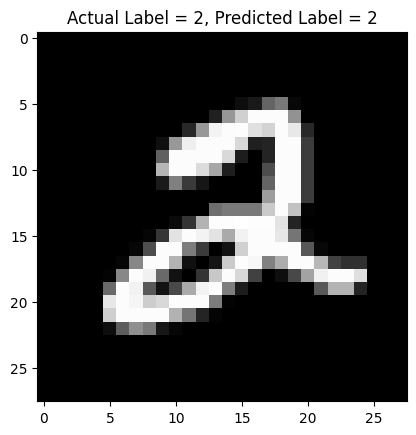

In [ ]:
output_label(model, 5)